# 作業 1 : 辨識名畫的作者

資料集: [Best Artworks of All Time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)

程式碼參考自: [Tensorflow](https://www.tensorflow.org/)

> **資料集說明**

After being challenged many times by my girlfriend about who is the best to guess the painter, I decided to use the power of machine learning to defeat her.I gathered a collection of artworks of the 50 most influential artists of all time.

請幫幫資料集作者完成他女朋友的挑戰。**訓練一個 CNN 模型輸入是一張畫作，辨識出這張畫可能是哪個畫家的作品。**


>**作業說明**

**第一步驟**: 左上角 檔案 -> 在雲端硬碟建立副本。

**第二步驟**: 右上角 共用 -> 取得連結 -> 任何知道這個連結的人都能編輯

**第三步驟**: 左上角 執行階段 -> 更變執行類型 -> GPU。可以加快模型速度

**第四步驟**: 檔案名稱，請填寫你的學號，把副本上下引號刪掉

請 **隨意修改** 這個 colab 的程式來完成訓練 CNN 模型。**只要跑得出來 Testing Accuracy、Loss; 1~7 個作業項目即可**，不必一定要照著 todo 提示走。
繳交時記得改檔案標題的學號。

本次作業著重在前處理，現實中很多筆資料的 label 不見得會直接給你，很多都會在奇怪的位置，例如本次作業，label 隱藏在圖片名稱之中。你需要做很多前處理來提取標籤。

> **作業限制**

1. 不要動資料集、不要在訓練時偷看 test data
2. 模型請手刻、手疊，**不要用 Transfer Learning** 來引入 ResNet、Inception...等知名模型來增加準確率。
3. **不要抄襲**

> **作業繳交**

1. 完成訓練後保存 output 結果，更改**檔名學號**，左上角 檔案 -> 下載 -> 下載.ipynb檔。
2. 交一個 pdf 檔，裡面需要附上**你的作業 colab 連結(設為可編輯)**、姓名學號年級、過程和執行結果的截圖，並說明你程式撰寫的過程、本次作業心得(字數不限)。
3. 文件內至少應貼上你的 Test Acc
4. 上述兩個檔案繳交至 ee-class。

> **算分標準**

20 + Test_Acc + Predict function(10 分) + 20 分文件
1. 20 分免費送
2. Test_Acc (1 分/1%)
3. predict_author 有寫出來就 10 分(第七段)
4. 20 分是文件分數
    - 姓名、學號、年級
    - colab 連結
    - Test accuracy
    - 撰寫過程與截圖
    - 心得

(明年推薦)
1. 10 分免費送
2. Val_Acc - 50% (20%) (1 分/1%) (有 70% 就滿分)
3. Test_Acc (40%) (1 分/1%)
4. predicrt_author (10%)
5. 文件分 (20%)

有問題再來信助教: lexlie.yunglinchu@gmail.com

### 資料集下載

- 資料集說明 :
  - artists.csv : dataset of information for each artist
  - train_resized/ : image dataset of training paintings. Image name contain image author's name.
  - test_resized/ : image dataset of testing paintings. Image name contain image author's name.
  - 詳細內容可以下載完點擊 colab 左側**檔案**來查看

- 下載連結：
  - train: https://drive.google.com/file/d/1K3FRVeabwV7TxboRsrkFcT34tPV9DWqr/view?usp=sharing
  - test: https://drive.google.com/file/d/1GCzWxFrIbb4d1JSXSrt3kRb6uERVqXpx/view?usp=sharing



In [18]:
import random
import os
from google.colab import drive #為了掛載google drive

# 大家盡量先把資料保存在本地端，然後要訓練時用本地端上傳做訓練
# 以節省學術網路資源，避免 IP 被封鎖

# 從drive讀資料 -> 不用每次重開colab就需要手動上傳（手動上傳要等一陣子）
drive.mount('/content/drive')

train_zip_path = "/content/drive/MyDrive/ML_HW1_Dataset/train.zip"
test_zip_path = "/content/drive/MyDrive/ML_HW1_Dataset/test.zip"

if os.path.isfile(train_zip_path) and os.path.isfile(test_zip_path):
    os.system(f"unzip -q {train_zip_path} -d /content/")
    os.system(f"unzip -q {test_zip_path} -d /content/")
    print("檔案成功解壓縮")
else:
    if not os.path.isfile(train_zip_path):
        print("找不到train.zip")
    if not os.path.isfile(test_zip_path):
        print("找不到test.zip")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
檔案成功解壓縮


## 1. 讀入封包

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import random
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping

## 2. 取得資料集

- **我們來檢視一下 artist.csv**，重要內容包含:
  - 畫家名稱 (name)
  - 風格 (genre)
  - 資料集內畫作數量 (paintings)

總共有 50 位畫家，意謂著有 50 個 class 要去辨識。

In [20]:
train_dir = "./train_resized/"
test_dir = "./test_resized/"
artists = pd.read_csv("./artists.csv")
num_classes = artists.shape[0]
print("Number of artists : ", num_classes)
artists.head()

Number of artists :  50


id                name        years                         genre  \
0   0   Amedeo Modigliani  1884 - 1920                 Expressionism   
1   1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism   
2   2        Diego Rivera  1886 - 1957       Social Realism,Muralism   
3   3        Claude Monet  1840 - 1926                 Impressionism   
4   4       Rene Magritte  1898 - 1967      Surrealism,Impressionism   

  nationality                                                bio  \
0     Italian  Amedeo Clemente Modigliani (Italian pronunciat...   
1     Russian  Wassily Wassilyevich Kandinsky (Russian: ?а?и?...   
2     Mexican  Diego María de la Concepción Juan Nepomuceno E...   
3      French  Oscar-Claude Monet (; French: [klod m?n?]; 14 ...   
4     Belgian  René François Ghislain Magritte (French: [??ne...   

                                        wikipedia  paintings  
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193  
1  http://en.wikipedia.org/wiki/Wassily_Kandinsky         88  
2       http://en.wikipedia.org/wiki/Diego_Rivera         70  
3       http://en.wikipedia.org/wiki/Claude_Monet         73  
4      http://en.wikipedia.org/wiki/René_Magritte        194

* 只取出名字與畫的數量，把名字用下底線連起來

In [21]:
artists = artists.loc[:, ["name", "paintings"]]
artists["name"] = artists["name"].str.split(" ").apply(lambda parts: "_".join(parts))
artists.head()

name  paintings
0   Amedeo_Modigliani        193
1  Vasiliy_Kandinskiy         88
2        Diego_Rivera         70
3        Claude_Monet         73
4       Rene_Magritte        194

* **計算各個畫家畫作數量**
* 每個 class 資料的不平衡容易影響模型的訓練，學生可以嘗試解決這個問題。(提示: keras 的 class_weight)

可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。
最多畫作為 :  877  最少畫作為 :  24


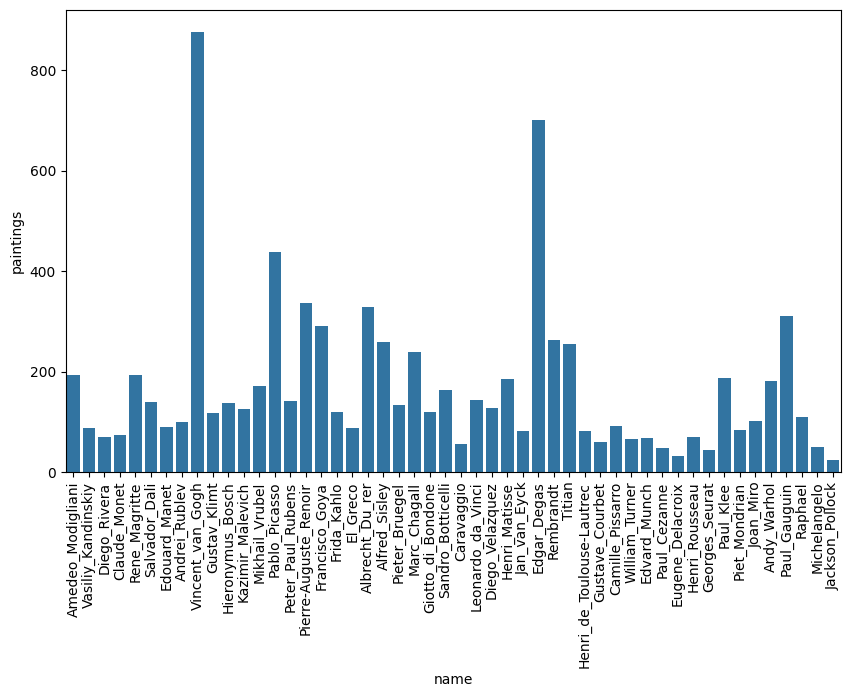

In [22]:
%matplotlib inline
plt.figure(figsize=(10, 6))

barplot = sns.barplot(x=artists.name,  y=artists.paintings)
for item in barplot.get_xticklabels():
    item.set_rotation(90)

print("可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。")
print("最多畫作為 : ", artists.paintings.max(), " 最少畫作為 : ", artists.paintings.min())

* 隨機讀取畫作來看看

training 畫作總共畫作有 :  7520


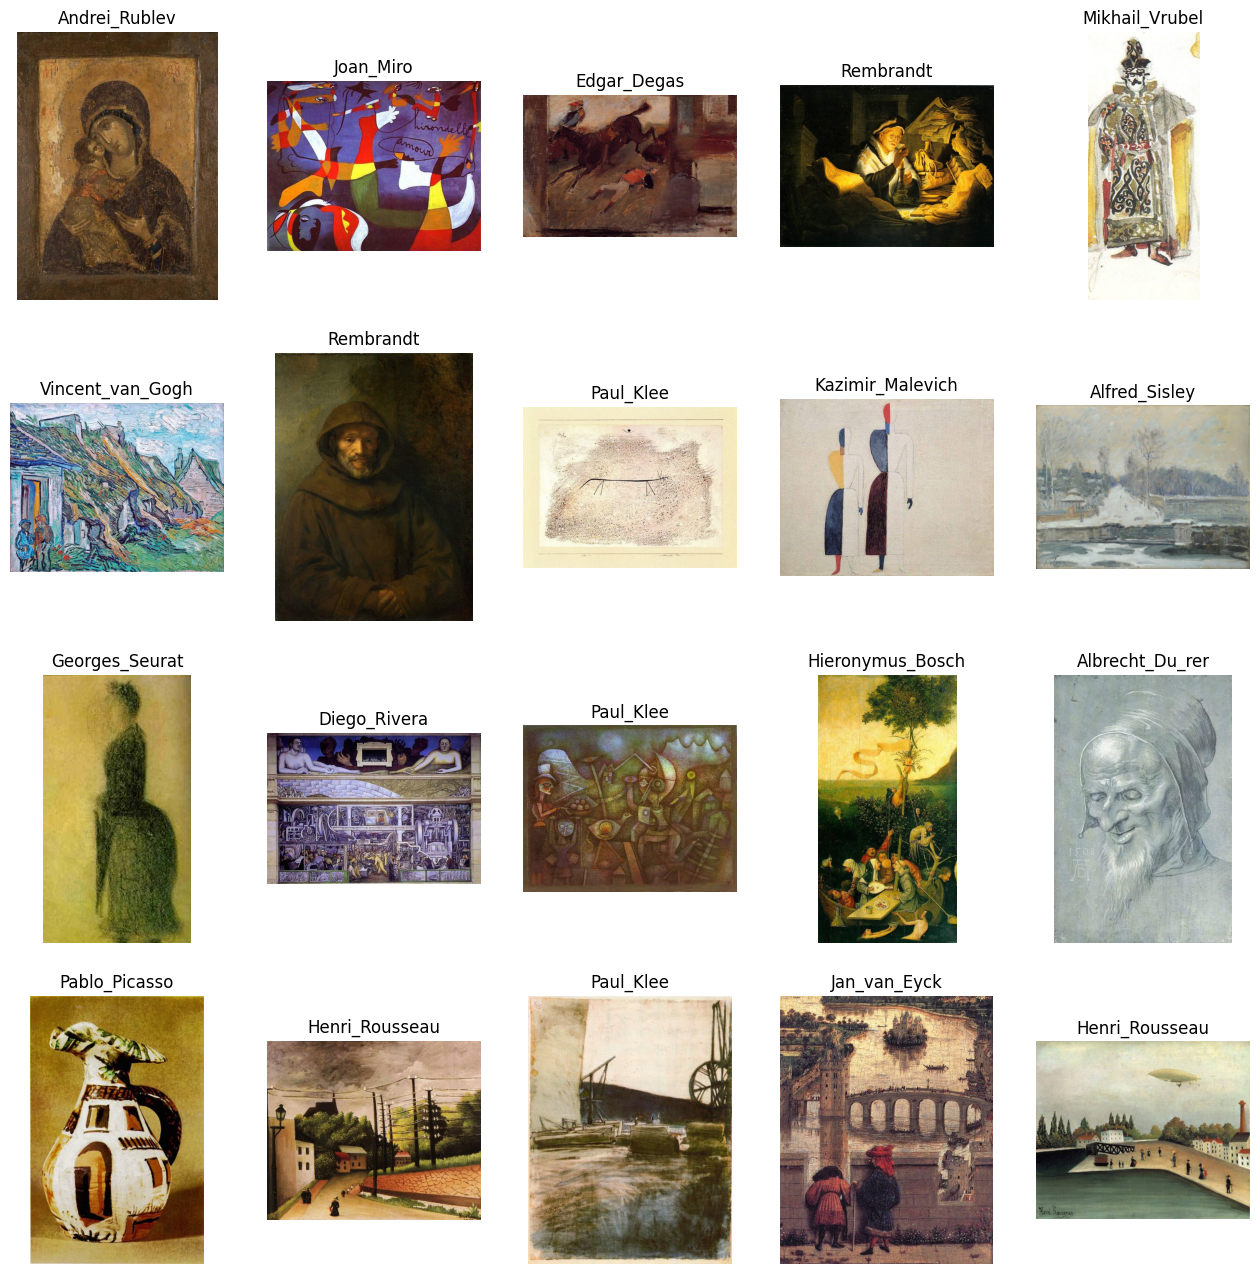

In [23]:
img_list = os.listdir(train_dir)
total_len = len(img_list)
random_list = random.sample(range(0, total_len), 20)
print("training 畫作總共畫作有 : ", total_len)

show_imgs = [img_list[rand] for rand in random_list]

plt.figure(figsize=(16, 16))
for index, imgName in enumerate(show_imgs):
    img_path = train_dir + imgName
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(4, 5, index + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("_".join(imgName.split("_")[:-1]))

## 3. 資料前處理

**有幾個重要的點需要處理**
1. 我們現在只有各個畫的路徑。Ex: /content/train_resized/Claude_Monet_22.jpg 。要取出 label : Claude_Monet
2. label (作者名稱)是英文，我們要先把英文映射成數字。EX: Van_Gogh --> 0 ; Edvard_Munch --> 1
3. label 數字還要轉成 50 depth 的 one_hot
4. 現在有畫的路徑了，要讀取圖片
5. 每張圖片的大小不一樣，要統一大小才能輸入模型
6. 把每張圖片正規化，映射到 [0,1] 之間
7. 路徑是按照作者名稱排列的，太整齊了，把資料集打散(shuffle)。
8. 如果有需要，拆分成訓練用資料(training_data)、驗證用(validation_data)
9. **重要!** 確定好你資料 input output 的維度，才能開始建立模型。EX: input:(256,256,3); output:(50,)

**助教推薦一個好用的工具** from_tensor_slices [參考](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

* from_tensor_slices 可以輕鬆的讀取想要的資料，把圖片路徑傳入 tensor 後用 map 將路徑轉成圖片檔案。

* **以下程式 todo 只是提供程式思路，你完全可以不理他，反正 test 結果能出來就好。**

In [24]:
# todo

#之後在訓練模型時會用 class_name[artist_name] 得到標籤，在預測後再用 rev_class_name[predicted_index] 轉回藝術家名稱。

def make_author_dict():

    # 存取所有不重複的artists的name
    artists_names = artists["name"].unique()

    # 做mapping -> {artist_name: index}
    label_map = {name: index for index, name in enumerate(artists_names)}

    # 反向mapping -> {index: artist_name}
    rev_label_map = {index: name for name, index in label_map.items()}

    return label_map, rev_label_map

# 請建立將英文映射成數字的 dict。EX: Van_Gogh --> 0 (class_name)
# 請建立將數字映射成英文的 dict。 EX: 0 --> Van_Gogh (rev_class_name)
class_name, rev_class_name = make_author_dict()

print("英文映射成數字: ", class_name)
print("數字映射成英文: ", rev_class_name)

英文映射成數字:  {'Amedeo_Modigliani': 0, 'Vasiliy_Kandinskiy': 1, 'Diego_Rivera': 2, 'Claude_Monet': 3, 'Rene_Magritte': 4, 'Salvador_Dali': 5, 'Edouard_Manet': 6, 'Andrei_Rublev': 7, 'Vincent_van_Gogh': 8, 'Gustav_Klimt': 9, 'Hieronymus_Bosch': 10, 'Kazimir_Malevich': 11, 'Mikhail_Vrubel': 12, 'Pablo_Picasso': 13, 'Peter_Paul_Rubens': 14, 'Pierre-Auguste_Renoir': 15, 'Francisco_Goya': 16, 'Frida_Kahlo': 17, 'El_Greco': 18, 'Albrecht_Du_rer': 19, 'Alfred_Sisley': 20, 'Pieter_Bruegel': 21, 'Marc_Chagall': 22, 'Giotto_di_Bondone': 23, 'Sandro_Botticelli': 24, 'Caravaggio': 25, 'Leonardo_da_Vinci': 26, 'Diego_Velazquez': 27, 'Henri_Matisse': 28, 'Jan_van_Eyck': 29, 'Edgar_Degas': 30, 'Rembrandt': 31, 'Titian': 32, 'Henri_de_Toulouse-Lautrec': 33, 'Gustave_Courbet': 34, 'Camille_Pissarro': 35, 'William_Turner': 36, 'Edvard_Munch': 37, 'Paul_Cezanne': 38, 'Eugene_Delacroix': 39, 'Henri_Rousseau': 40, 'Georges_Seurat': 41, 'Paul_Klee': 42, 'Piet_Mondrian': 43, 'Joan_Miro': 44, 'Andy_Warhol': 45, '

In [25]:
# todo
def get_label(pic_name, label_map):
    # 請取出 label 並轉成數字
    # EX: Claude_Monet_1.jpg -> Claude_Monet -> 1

    pic_name = pic_name.split('.')[0]
    name_parts = pic_name.split('_')

    # author_name = 名字+姓氏，並去掉編號
    author_name = '_'.join(name_parts[:-1])

    if author_name not in label_map:
        raise ValueError(f"unknown artists：{author_name}")

    return label_map[author_name]


# todo
def get_path(dir, pic_name):
    # 請將路徑合併
    # EX: ./train_resized/ + Claude_Monet_1.jpg => ./train_resized/Claude_Monet_1.jpg

    path = os.path.join(dir, pic_name)

    return path


# todo
def make_paths_label(dir):
    img_list = os.listdir(dir)
    paths = []
    labels = []

    # 將preprocess完成的 path、label 用 for 迴圈放入 paths 和 labels
    for img_name in img_list:
        path = get_path(dir, img_name)
        label = get_label(img_name, class_name)
        paths.append(path)
        labels.append(label)

    # 要產生幾維的 onehot
    num_classes = len(class_name)

    # 將 labels 轉成 onehot
    onehot_labels = keras.utils.to_categorical(labels, num_classes=num_classes)

    return paths, onehot_labels

In [26]:
# 來查看一下
paths, onehot_labels = make_paths_label(train_dir)
ld=2
print("paths : ")
for p in paths[:5]:
    print(p)
print("-" * 20)
print("labels : ")
for label in onehot_labels[:5]:
    print(label)

paths : 
./train_resized/Alfred_Sisley_96.jpg
./train_resized/Salvador_Dali_99.jpg
./train_resized/Edouard_Manet_37.jpg
./train_resized/Pierre-Auguste_Renoir_233.jpg
./train_resized/Edouard_Manet_88.jpg
--------------------
labels : 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 

* 目標輸出

![](https://i.imgur.com/CSzFlZ2.png)

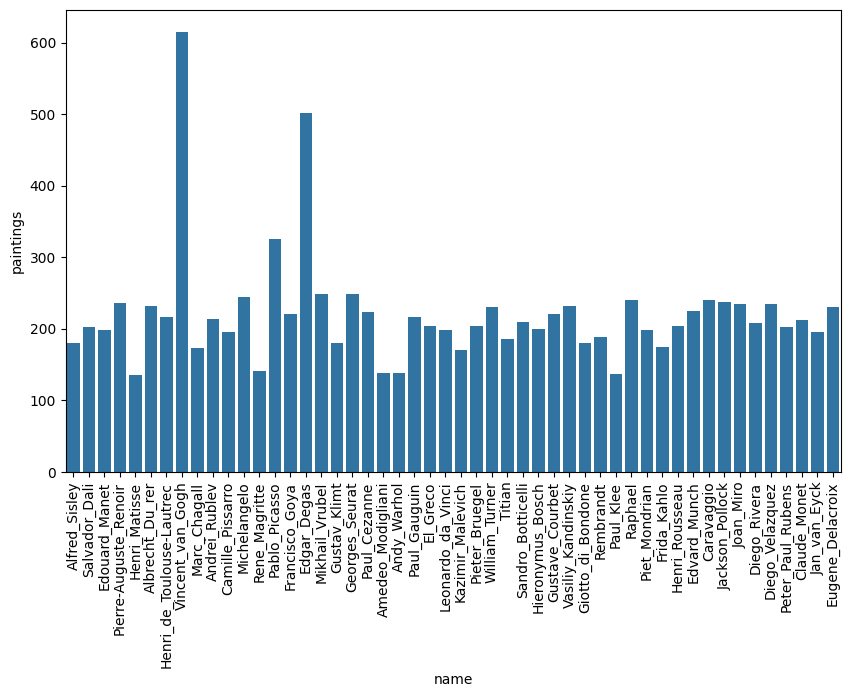

Train size (oversampling前): 6016  ⮕ after (estimated): 11017
Val size: 1504


In [27]:
# 決定你輸入模型的圖片長寬
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
# shuffle buffer size
SHUFFLE_BUFFER = 1000

# todo
def get_image(path):
    # read image from path
    file = tf.io.read_file(path)
    img = tf.io.decode_jpeg(file, channels=3)
    img = tf.cast(img, tf.float32)

    # 請固定每張圖片大小為 IMG_HEIGHT、IMG_WIDTH
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    # 並將圖片每個 pixel 映射到 [0,1] 之間
    img = img / 255.0

    return img


# （自己加入的內容）資料增強 -> 減少overfitting
def load_image_with_augmentation(path, label):
    img = get_image(path)

    img = tf.image.random_flip_left_right(img)    # 隨機左右翻轉
    img = tf.image.random_brightness(img, max_delta=0.1)    # 隨機調整亮度
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)     # 隨機調整對比度
    img = tf.image.random_saturation(img, lower=0.9, upper=1.1)    # 隨機調整飽和度
    img = tf.image.random_hue(img, max_delta=0.01)     # 隨機調整色相

    img = tf.clip_by_value(img, 0.0, 1.0)

    return img, label


# （自己加入的內容）oversampling
def make_balanced_dataset(paths, labels):

    label_counts = Counter(labels)
    threshold = 250

    aug_paths, aug_labels = [], []

    for path, label in zip(paths, labels):

        # 保留原始圖片
        aug_paths.append(path)
        aug_labels.append(label)

        # 圖片數量低於threshold就進行 oversampling
        if label_counts[label] < threshold:
            repeat_times = (threshold - label_counts[label]) // label_counts[label]
            for _ in range(repeat_times):
                # 重複加入原始圖片的路徑和標籤
                aug_paths.append(path)
                aug_labels.append(label)

    # 轉為 onehot
    num_classes = len(set(aug_labels))
    onehot_labels = keras.utils.to_categorical(aug_labels, num_classes=num_classes)

    path_ds = tf.data.Dataset.from_tensor_slices(aug_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(onehot_labels)

    full_ds = tf.data.Dataset.zip((path_ds, label_ds))

    #資料增強
    full_ds = full_ds.map(load_image_with_augmentation)
    #batching
    full_ds = full_ds.shuffle(SHUFFLE_BUFFER).batch(32).prefetch(tf.data.AUTOTUNE)


    # 用圖表看oversampling後的分布⬇

    balanced_counts = Counter(aug_labels)

    df = pd.DataFrame.from_dict(balanced_counts, orient='index', columns=['paintings'])
    df = df.reset_index().rename(columns={"index": "label"})

    if 'rev_class_name' in globals():
        df["name"] = df["label"].apply(lambda idx: rev_class_name[idx])
    else:
        df["name"] = df["label"]

    plt.figure(figsize=(10, 6))
    sns.barplot(x="name", y="paintings", data=df)
    plt.xticks(rotation=90)
    plt.show()

    # 回傳平衡後的dataset
    return full_ds



# 先切割train跟val 再去做後續的oversample & augmentation
# 因為只有要針對train_ds做處理 沒有要動val_ds
def make_dataset(dir):

    paths, onehot_labels = make_paths_label(dir)
    total_len = len(paths)

    # 切割成 training data(80%) 與 validation data(20%)
    train_len = int(0.8 * total_len)
    val_len = total_len - train_len

    train_paths = paths[:train_len]
    train_labels = [np.argmax(l) for l in onehot_labels[:train_len]]

    val_paths = paths[train_len:]
    val_labels = onehot_labels[train_len:]

    # 處理training data -> oversampling + augmentation
    train_ds = make_balanced_dataset(train_paths, train_labels)

    # 預估oversampling後training data的size
    label_counts = Counter(train_labels)
    threshold = 250
    est_total = 0
    for count in label_counts.values():
        est_total += count
        if count < threshold:
            # 簡單的推估每張圖會被複製幾次(所以是estimated)
            repeat_times = (threshold - count) // count
            est_total += count * repeat_times

    # validation data（不做處理）
    val_path_ds = tf.data.Dataset.from_tensor_slices(val_paths)
    val_label_ds = tf.data.Dataset.from_tensor_slices(val_labels)
    val_img_ds = val_path_ds.map(get_image)
    val_ds = tf.data.Dataset.zip((val_img_ds, val_label_ds)).batch(32).prefetch(tf.data.AUTOTUNE)

    print("Train size (oversampling前):", len(train_paths), f" ⮕ after (estimated): {est_total}")
    print("Val size:", len(val_paths))

    return train_ds, val_ds

train_ds, val_ds = make_dataset(train_dir)

In [28]:
# 建立測試資料集(test)
def make_test_dataset(test_dir):

    paths, onehot_labels = make_paths_label(test_dir)

    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    label_ds = tf.data.Dataset.from_tensor_slices(onehot_labels)

    # resize + normalize
    img_ds = path_ds.map(lambda p: get_image(p))

    test_ds = tf.data.Dataset.zip((img_ds, label_ds)).batch(50)
    return test_ds

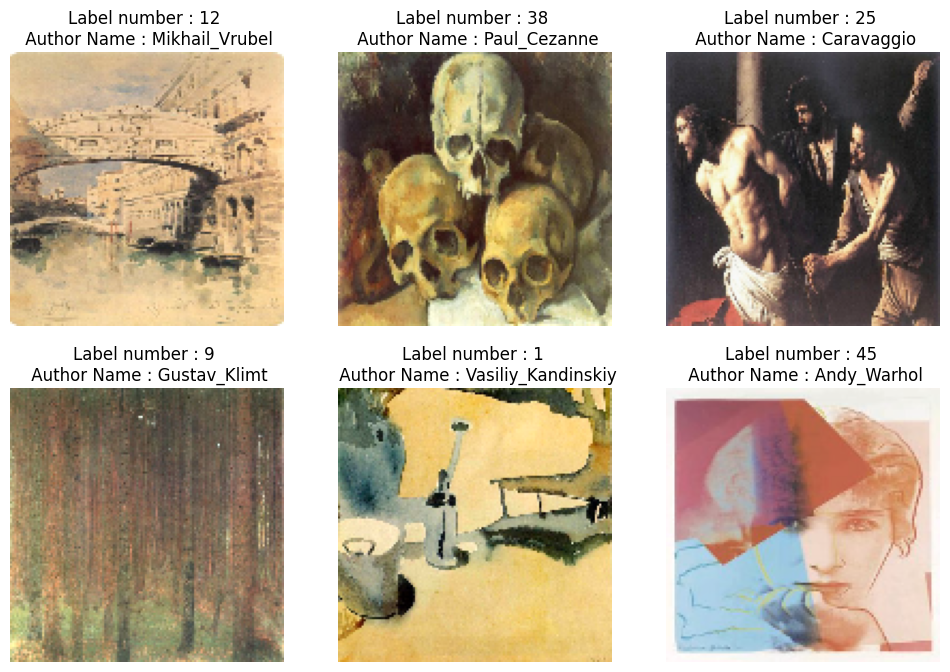

In [29]:
# 取出 Tensor 圖片來看看
plt.figure(figsize=(12, 8))
for image_batch, label_batch in train_ds.take(1):
    for index in range(6):
        img = image_batch[index].numpy()
        label = label_batch[index].numpy()
        l = np.argmax(label)

        plt.subplot(2, 3, index + 1)
        plt.imshow(img)
        plt.title("Label number : {} \n Author Name : {}".format(l, rev_class_name[l]))
        plt.axis("off")

* 目標輸出

![](https://i.imgur.com/gvwxegB.png)

In [30]:
# 查看添加batch後的維度
trainiter = iter(train_ds)
x, y = next(trainiter)
print("training image batch shape : ", x.shape)
print("training label batch shape : ", y.shape)

training image batch shape :  (32, 128, 128, 3)
training label batch shape :  (32, 50)


## 4. 建立模型

發揮你的創意，建立模型。

請不要用已有的知名模型做 fine-tuning，**請自己手動建**。

In [31]:
input_shape = (128, 128, 3)
num_classes = 50

from tensorflow.keras import regularizers

# 自訂你的 model

model = keras.Sequential([
    keras.Input(shape=input_shape),

    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    layers.Flatten(),


    layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-5)),
    layers.BatchNormalization(),
    layers.Dropout(0.6),

    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-5)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation="softmax"),
])


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,625,778 (17.65 MB)

 Trainable params: 4,624,050 (17.64 MB)

 Non-trainable params: 1,728 (6.75 KB)

## 5. 制定訓練計畫

把前處理完的資料輸入進去

In [32]:
# todo
#from keras.callbacks import EarlyStopping, ReduceLROnPlateau

EPOCHS = 40

optimizer = keras.optimizers.Adam(learning_rate=5e-5)

# model.compile 決定 learning strategy、Loss calculator
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# val_loss 連續未改善 -> 停止訓練
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[early_stop])

Epoch 1/40
345/345 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - accuracy: 0.0364 - loss: 4.7637 - val_accuracy: 0.0332 - val_loss: 4.3158
Epoch 2/40
345/345 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.0876 - loss: 4.0773 - val_accuracy: 0.2214 - val_loss: 3.2491
Epoch 3/40
345/345 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - accuracy: 0.1313 - loss: 3.7779 - val_accuracy: 0.2380 - val_loss: 3.0895
Epoch 4/40
345/345 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - accuracy: 0.1567 - loss: 3.5394 - val_accuracy: 0.2653 - val_loss: 2.9996
Epoch 5/40
345/345 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - accuracy: 0.1908 - loss: 3.3392 - val_accuracy: 0.2819 - val_loss: 2.9202
Epoch 6/40
345/345 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.2194 - loss: 3.1907 - val_accuracy: 0.2852 - val_loss: 2.8649
Epoch 7/40
345/345 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - accuracy: 0.2292 - loss: 3.0650 - val_accuracy: 0.2992 - val_loss: 2.7770
Epoch 8/40
345/345 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - accuracy: 0.2728 - loss: 2.8943 -

## 6. 評估模型

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


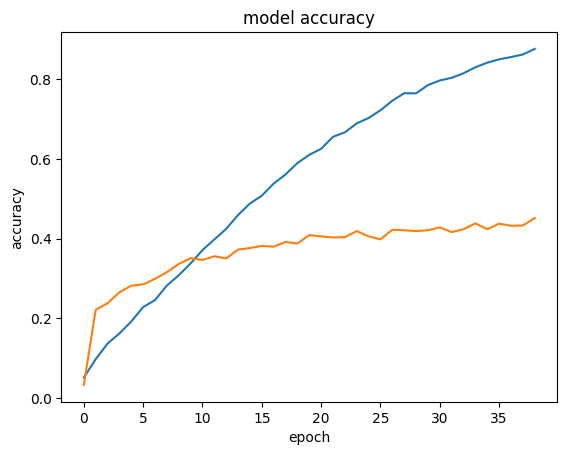

In [33]:
print(history.history.keys())

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

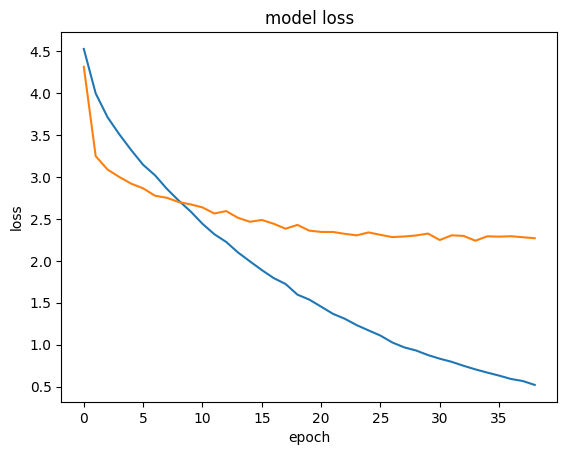

In [34]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")

plt.show()

In [35]:
# 讀入測試資料並評估模型
test_ds = make_test_dataset(test_dir)

# 評估模型
score = model.evaluate(test_ds)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.4434 - loss: 2.1549
Test loss: 2.1944708824157715
Test accuracy: 0.4395209550857544


## 7. 做預測 (10分)
* 把前面讀取的圖片拿來丟入模型做預測
* 自己把一張現實中的圖片丟入 Model 做預測

In [36]:
# to-do

def predict_author(img):
    # 寫個單圖片模型預測 function
    # input : opencv img (height,width,3)
    # output : 某個作家名字 E.g. Claude_Monet

    # 1. expand img dimension (height,width,3) -> (1,height,width,3)
    img = np.expand_dims(img, axis=0)

    # 2. 丟入模型 model.predict + 3. 取出 softmax 後 (50,) 取最大值的 index 作為辨識結果
    pred_idx = np.argmax(model.predict(img, verbose=0)[0])

    # 4. 將辨識結果轉為畫作家名字
    return rev_class_name.get(pred_idx, "Unknown")

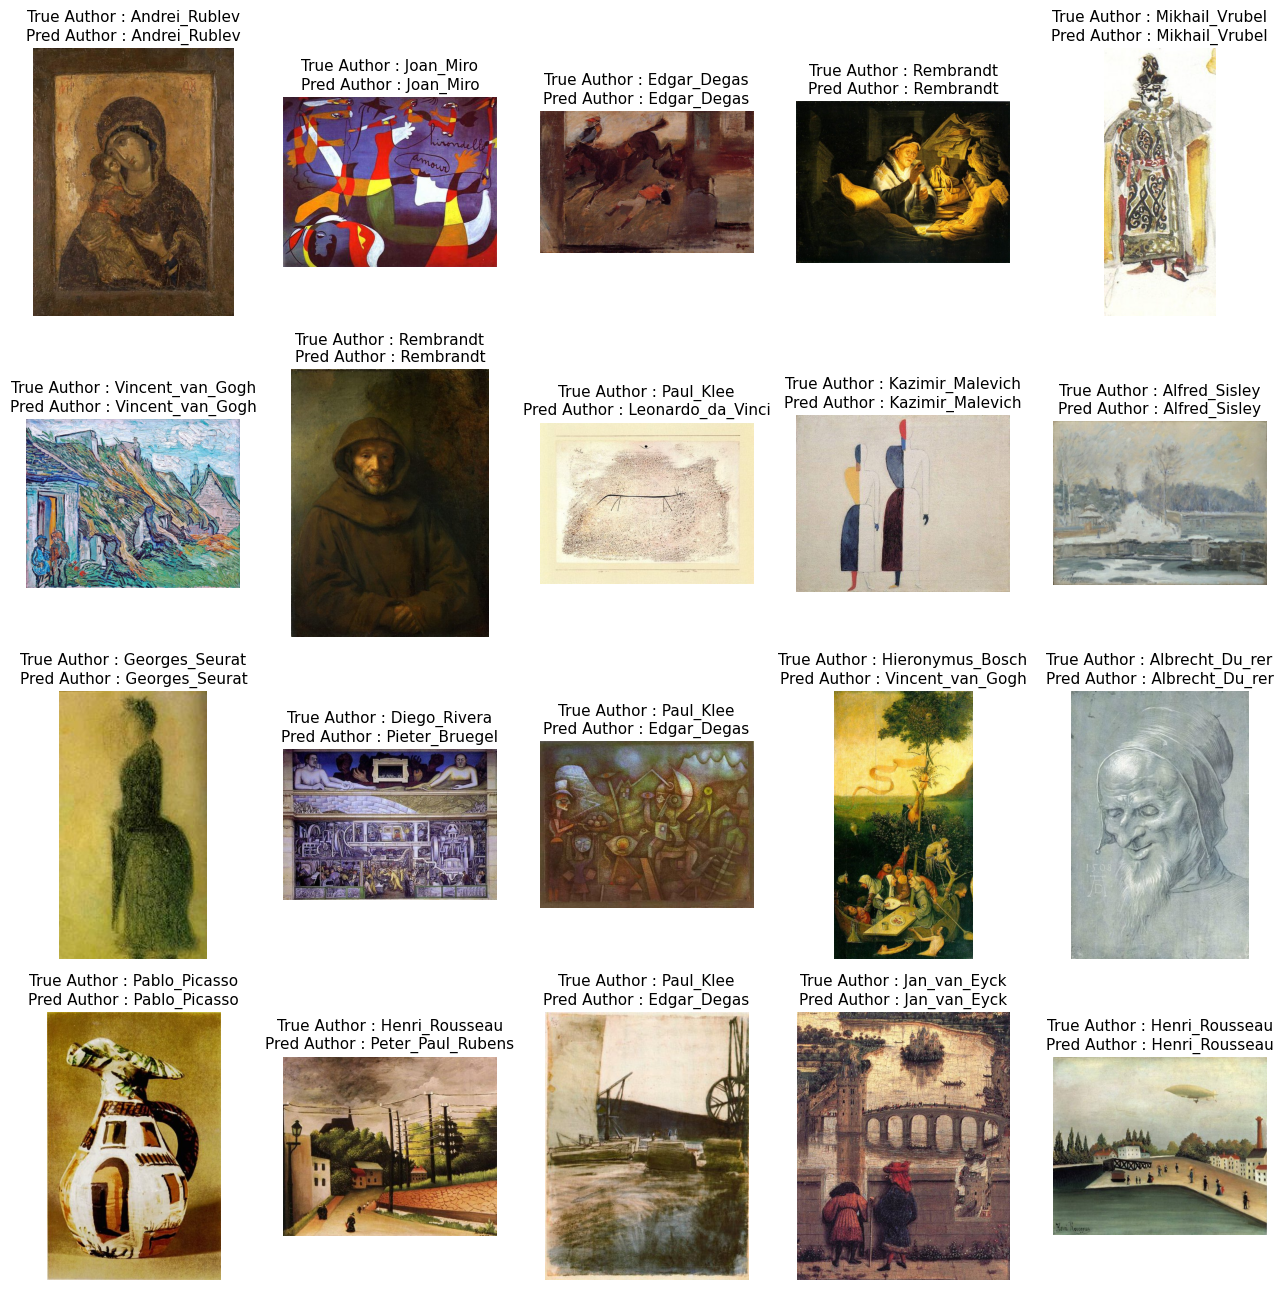

In [37]:
plt.figure(figsize=(16, 16))
for index, imgName in enumerate(show_imgs):
    img_path = train_dir + imgName
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(4, 5, index + 1)
    plt.axis("off")
    plt.imshow(img)
    img = cv.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0
    true_author = "_".join(imgName.split("_")[:-1])
    pred_author = predict_author(img).replace(" ", "_")
    plt.title(
        "True Author : {}\nPred Author : {}".format(
            true_author, pred_author
        ),
        size=11,
    )

* 期望結果
![](https://i.imgur.com/ZEtd7yf.png)

* 自己上傳圖片來試試看模型的效果

In [38]:
from google.colab import files


def upload_img():
    uploaded = files.upload()
    img_name = list(uploaded.keys())[0]
    img = cv.imread(img_name)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    img = cv.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0
    return img


def eval():
    img = upload_img()
    plt.title("predict author : {}".format(predict_author(img).replace(" ", "_")))
    plt.axis("off")
    plt.show()

Saving Me.jpg to Me.jpg


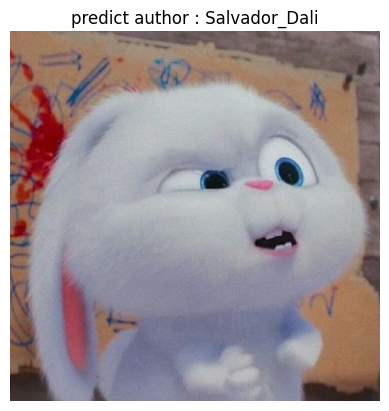

In [39]:
# 自己上傳一張圖片來試試看
# Demo 圖片來自:
# Interview with Cyberpunk 2077 "ponpon shit" producer Yuki Kawamura (https://block.fm/news/cyberpunk2077_uscracks_ENG)
eval()